In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.metrics import f1_score


In [2]:
import tensorflow as tf

2025-01-05 14:49:57.975108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736081397.987174   28250 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736081397.990807   28250 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 14:49:58.004430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
x_train_scaled_df = pd.read_pickle("./x_train_scaled_df.pkl")
y_train = np.load("./y_train.npy")

In [42]:
x_val_scaled_df = pd.read_pickle("./x_val_scaled_df.pkl")
y_val = np.load("./y_val.npy")

In [43]:
x_train = x_train_scaled_df.to_numpy()
x_val = x_val_scaled_df.to_numpy()

In [44]:
x_train_num = x_train[:,2:]
x_train_num = np.array(x_train_num, dtype=np.float32)
x_val_num = x_val[:,2:]
x_val_num = np.array(x_val_num, dtype=np.float32)

x_train_loan = x_train[:,1]
x_val_loan = x_val[:,1]

x_train_lender = x_train[:,0]
x_val_lender = x_val[:,0]

In [54]:
loan_types_unique_list = list(x_train_scaled_df['loan_type'].unique())
lenders_unique_list = list(x_train_scaled_df['lender_id'].unique())

NameError: name 'x_train_scaled_df' is not defined

In [22]:
def embedding_output_dim(input_dim):
    return round((1.6*input_dim)**0.56)

In [3]:
tf.keras.backend.clear_session()

In [24]:
tf.random.set_seed(42)
loan_type_look_up_layer = tf.keras.layers.StringLookup()
loan_type_look_up_layer.adapt(loan_types_unique_list)
lookup_and_embed_loan_type = tf.keras.Sequential([
    loan_type_look_up_layer,
    tf.keras.layers.Embedding(input_dim=loan_type_look_up_layer.vocabulary_size(), output_dim=embedding_output_dim(loan_type_look_up_layer.vocabulary_size())),
    tf.keras.layers.Flatten()
])


I0000 00:00:1736010377.577860    8218 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9899 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:10:00.0, compute capability: 8.6


In [25]:
lender_type_look_up_layer = tf.keras.layers.StringLookup()
lender_type_look_up_layer.adapt(lenders_unique_list)
lookup_and_embed_lender_type = tf.keras.Sequential([
    lender_type_look_up_layer,
    tf.keras.layers.Embedding(input_dim=lender_type_look_up_layer.vocabulary_size(), output_dim=embedding_output_dim(lender_type_look_up_layer.vocabulary_size())),
    tf.keras.layers.Flatten()
])

In [26]:
num_input = tf.keras.layers.Input(shape=[15], name="num")
loan_cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="loan_cat")
lender_cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="lender_cat")

loan_embeddings = lookup_and_embed_loan_type(loan_cat_input)
lender_embeddings = lookup_and_embed_lender_type(lender_cat_input)
encoded_inputs = tf.keras.layers.concatenate([num_input, loan_embeddings, lender_embeddings])

number_of_neurons_per_layer = 200
number_of_layers_deep = 15
number_of_layers_wide = 0
activation = tf.keras.activations.silu 
kernel_innit = "he_normal"



deep_path = encoded_inputs
for i in range(number_of_layers_deep): 
    deep_path = tf.keras.layers.BatchNormalization()(deep_path)
    deep_path = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=activation, kernel_initializer=kernel_innit)(deep_path)

# Wide path
wide_path = encoded_inputs
for i in range(number_of_layers_wide):  # number_of_layers_wide
    wide_path = tf.keras.layers.BatchNormalization()(wide_path)
    wide_path = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=activation, kernel_initializer=kernel_innit)(wide_path)

# Combine deep and wide paths
concat_layer = tf.keras.layers.concatenate([deep_path, wide_path])

last_dense = tf.keras.layers.Dense(units=number_of_neurons_per_layer, activation=activation, kernel_initializer=kernel_innit)(concat_layer)

# Output layer
output = tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=kernel_innit)(last_dense)

# Define the model
model_ = tf.keras.Model(inputs=[num_input, loan_cat_input, lender_cat_input], outputs=output)


In [27]:
learning_rate = 0.001
Optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.005, monitor="val_pr_auc")
Loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.98, gamma=3.0)
Metrics =  [tf.keras.metrics.AUC(name='pr_auc', curve='PR'), tf.keras.metrics.RecallAtPrecision(precision=0.8)]
Batch_Size = 32
Epochs = 50

In [28]:
model_.compile(
    optimizer=Optimizer,  
    loss=Loss,
    metrics=Metrics,
)

In [41]:
history = model_.fit(
    (x_train_num, x_train_loan, x_train_lender),
    y_train,
    callbacks=[early_stop],
    batch_size=Batch_Size,
    epochs=Epochs,
    validation_data=((x_val_num, x_val_loan, x_val_lender), y_val)
)

Epoch 1/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0055 - pr_auc: 0.7174 - recall_at_precision: 0.5334 - val_loss: 0.0119 - val_pr_auc: 0.5521 - val_recall_at_precision: 0.2480
Epoch 2/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - loss: 0.0039 - pr_auc: 0.7970 - recall_at_precision: 0.6179 - val_loss: 0.0052 - val_pr_auc: 0.7854 - val_recall_at_precision: 0.6560
Epoch 3/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - loss: 0.0035 - pr_auc: 0.8306 - recall_at_precision: 0.6627 - val_loss: 0.0061 - val_pr_auc: 0.7992 - val_recall_at_precision: 0.5680
Epoch 4/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 0.0036 - pr_auc: 0.8411 - recall_at_precision: 0.7186 - val_loss: 0.0294 - val_pr_auc: 0.6888 - val_recall_at_precision: 0.4000
Epoch 5/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0031 - pr_auc: 0.8595 - recall_at_precision: 0.7700 - val_loss: 0.0105 - val_pr_auc: 0.7811 - val_recall_at_precision: 0.5120
Epoch 6/50
1931/1931 ━━━━━━━━━━━━━━━━━━━

In [4]:
import matplotlib.pyplot as plt

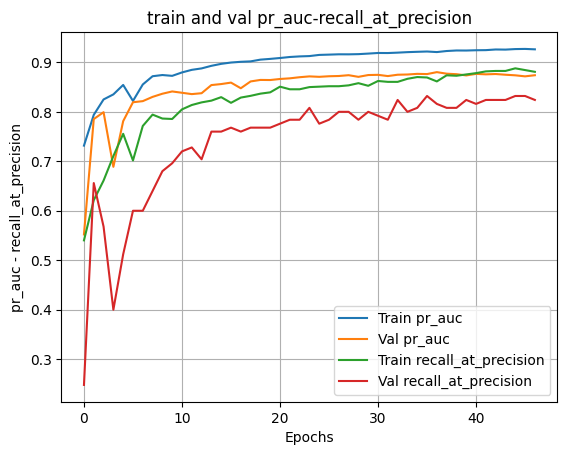

In [43]:
train_pr_auc = history.history['pr_auc']  
val_pr_auc = history.history['val_pr_auc']  

train_recall_at_precision = history.history['recall_at_precision']  
val_recall_at_precision = history.history['val_recall_at_precision']  


plt.plot(train_pr_auc, label='Train pr_auc')
plt.plot(val_pr_auc, label='Val pr_auc')
plt.plot(train_recall_at_precision, label='Train recall_at_precision')
plt.plot(val_recall_at_precision, label='Val recall_at_precision')
plt.xlabel('Epochs')
plt.ylabel('pr_auc - recall_at_precision')
plt.title('train and val pr_auc-recall_at_precision')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
#model_.save('model_1.keras')

In [48]:
#model_.save('model_2.keras')

In [45]:
model_reload = tf.keras.models.load_model('model_1.keras')

fit into validation data too later !

In [52]:
val_preds_NN = model_reload.predict((x_val_num, x_val_loan, x_val_lender))

215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [3]:
def classify_from_model(preds, threshold):
    return np.where(preds>threshold, 1, 0).astype(int).flatten()

In [4]:
def find_best_threshold(validation_preds, y_validation):
    arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
    for thres in range(0,100,1):
        arr_of_f1s[thres]= f1_score(y_pred=classify_from_model(validation_preds, thres/100), y_true=y_validation)
    best_f1_index = np.argmax(arr_of_f1s)
    best_f1 = arr_of_f1s[best_f1_index]
    print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index}")
    return arr_of_f1s

In [18]:
f1s = find_best_threshold(validation_preds=val_preds_NN, y_validation=y_val)

NameError: name 'val_preds_NN' is not defined

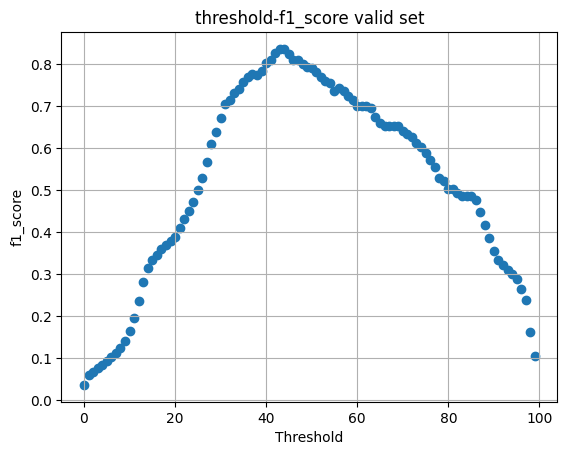

In [54]:
plt.scatter(x=range(100), y=f1s)
plt.xlabel('Threshold')
plt.ylabel('f1_score')
plt.title('threshold-f1_score valid set')
plt.grid(True)
plt.show()

In [5]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score
from functools import partial
from xgboost import XGBClassifier, DMatrix, train

In [19]:
from skopt import gp_minimize
from skopt import space

In [49]:
x_train_scaled_df[['loan_type', 'lender_id']] = x_train_scaled_df[['loan_type', 'lender_id']].astype("category")
x_train = x_train_scaled_df.copy()

In [50]:
x_val_scaled_df[['loan_type', 'lender_id']] = x_val_scaled_df[['loan_type', 'lender_id']].astype("category")
x_val = x_val_scaled_df.copy()

In [51]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)


In [52]:
x_train_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']] = x_train_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']].astype(float)

In [53]:
x_val_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']] = x_val_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']].astype(float)

In [54]:
scale_pos = sum(y_train==0) / sum(y_train==1)

In [10]:
def optimize_XGB(params, param_names, x, y):
    params= dict(zip(param_names, params))
    kf = StratifiedKFold(n_splits=5)
    auc_scores = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x.loc[train_idx]
        ytrain = y.loc[train_idx]
        
        xtest = x.loc[test_idx]
        ytest = y.loc[test_idx]
        
        
        model = XGBClassifier(**params, scale_pos_weight= scale_pos, enable_categorical=True, device="gpu")
        model.fit(xtrain, ytrain)
        preds = model.predict_proba(xtest)
        winner_one = preds[:, 1]
        auc = roc_auc_score(ytest, winner_one)
        auc_scores.append(auc)
    return -1.0 * np.mean(auc_scores)

param_space_XGB = [
    space.Integer(2, 8, name="max_depth"),
    space.Real(0.001, 1.0, prior="log-uniform" ,name="learning_rate"),
    space.Real(0.1, 1.0, prior="uniform" ,name="subsample"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bytree"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bylevel"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bynode"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_alpha"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_lambda"),
    space.Real(0.0, 15.0, prior="uniform" ,name="gamma"),
    
]
param_names_XGB = [
    "max_depth",
    "learning_rate",
    "subsample",
    "colsample_bytree",
    "colsample_bylevel",
    "colsample_bynode",
    "reg_alpha",
    "reg_lambda",
    "gamma",
   
    
]

optimization_function_XGB = partial(
    optimize_XGB,
    param_names = param_names_XGB,
    x = x_train,
    y = y_train
)

result_XGB =  gp_minimize(
    optimization_function_XGB,
    dimensions = param_space_XGB,
    verbose=10,
    n_calls=100,
)

print(
    dict(zip(param_names_XGB, result_XGB.x))
)

Iteration No: 1 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:26:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1733179782501/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.7691
Function value obtained: -0.9943
Current minimum: -0.9943
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.5494
Function value obtained: -0.9944
Current minimum: -0.9944
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.4859
Function value obtained: -0.9909
Current minimum: -0.9944
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.3382
Function value obtained: -0.9918
Current minimum: -0.9944
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0533
Function value obtained: -0.9926
Current minimum: -0.9944
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Ev

In [56]:
dtrain = DMatrix(x_train_scaled_df, label=y_train, enable_categorical=True)

In [57]:
dval = DMatrix(x_val_scaled_df, enable_categorical=True)

In [58]:
params = {
    'objective': 'binary:logistic',  
    'tree_method': 'hist',          
    'enable_categorical': True,     
    'max_depth': np.int64(5), 'learning_rate': 0.1459827666808464, 'subsample': 0.8731995463098501, 'colsample_bytree': 0.32671033490752127, 'colsample_bylevel': 0.7649860956775567, 'colsample_bynode': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 10.0, 'gamma': 1.6561198228345784, 'scale_pos_weight': scale_pos
}

In [59]:
model_xgb = train(params, dtrain, num_boost_round=100)

/home/thomasdev/tf/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:07:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
val_preds_xgb = model_xgb.predict(dval)

In [57]:
f1s = find_best_threshold(validation_preds=val_preds_xgb, y_validation=y_val)

Best f1 is 0.8 for threshold 34


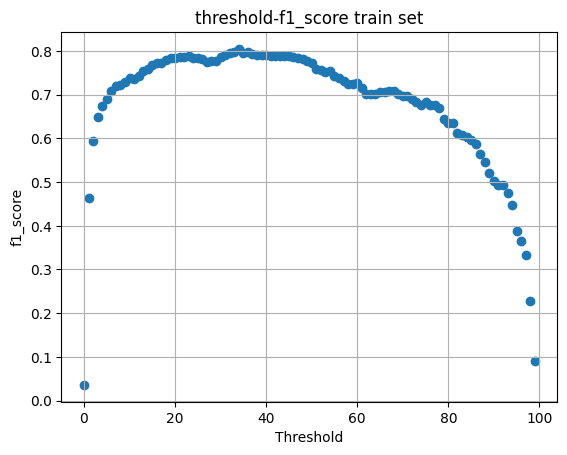

In [58]:
plt.scatter(x=range(100), y=f1s)
plt.xlabel('Threshold')
plt.ylabel('f1_score')
plt.title('threshold-f1_score train set')
plt.grid(True)
plt.show()

In [7]:
def final_make_preds_ensemple(model_NN, model_xgb, x_val_df, threshold, pca=False, NN_weight=0.5):
   x_val = x_val_df.to_numpy()
   x_val_num = x_val[:,2:]
   x_val_num = np.array(x_val_num, dtype=np.float32)
   x_val_loan = x_val[:,1]
   x_val_lender = x_val[:,0]
   val_preds_NN = model_NN.predict((x_val_num, x_val_loan, x_val_lender)).flatten()
   del x_val, x_val_num, x_val_loan, x_val_lender
   x_val_df[['loan_type', 'lender_id']] = x_val_df[['loan_type', 'lender_id']].astype("category")
   if pca==False:
      x_val_df[['Inflation, consumer prices (annual %)','Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender','repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration','power_Lender_portion_to_be_repaid', 'power_amount_per_day','power_total_money_borrowed', 'power_total_number_of_loans','power_usual_borrowed_ratio', 'power_repay_amount_overall','power_repay_amount_lender','power_Official exchange rate (LCU per US$, period average)']] = x_val_df[['Inflation, consumer prices (annual %)','Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender','repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration','power_Lender_portion_to_be_repaid', 'power_amount_per_day','power_total_money_borrowed', 'power_total_number_of_loans','power_usual_borrowed_ratio', 'power_repay_amount_overall','power_repay_amount_lender','power_Official exchange rate (LCU per US$, period average)']].astype(float)
   dval = DMatrix(x_val_df, enable_categorical=True)
   val_preds_xgb = model_xgb.predict(dval)
   final_preds = NN_weight*val_preds_NN+(1-NN_weight)*(val_preds_xgb)
   final_preds = classify_from_model(final_preds, threshold=threshold)
   return final_preds

In [112]:
preds = final_make_preds_ensemple(model_NN=model_reload, model_xgb=model_xgb, x_val_df=x_val_scaled_df, threshold=0.5)

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [61]:
arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
for thres in range(0,100,1):
    arr_of_f1s[thres]= f1_score(y_pred=final_make_preds_ensemple(model_NN=model_reload, model_xgb=model_xgb, x_val_df=x_val_scaled_df, threshold=thres/100), y_true=y_val)
best_f1_index = np.argmax(arr_of_f1s)
best_f1 = arr_of_f1s[best_f1_index]
print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━

Oversample

In [8]:
x_train_oversampled_df = pd.read_pickle("./x_oversampled_df.pkl")
y_train = np.load("./y_oversampled_arr.npy")

In [9]:
x_val_scaled_df = pd.read_pickle("./x_val_scaled_df.pkl")
y_val = np.load("./y_val.npy")

In [10]:
x_train = x_train_oversampled_df.to_numpy()
x_val = x_val_scaled_df.to_numpy()

In [11]:
x_train_num = x_train[:,2:]
x_train_num = np.array(x_train_num, dtype=np.float32)
x_val_num = x_val[:,2:]
x_val_num = np.array(x_val_num, dtype=np.float32)

x_train_loan = x_train[:,1]
x_val_loan = x_val[:,1]

x_train_lender = x_train[:,0]
x_val_lender = x_val[:,0]

In [11]:
model_reload = tf.keras.models.load_model('model_1.keras')

In [12]:
learning_rate = 0.001
Optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.005, monitor="val_pr_auc")
Loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.6, gamma=3.0)
Metrics =  [tf.keras.metrics.AUC(name='pr_auc', curve='PR'), tf.keras.metrics.RecallAtPrecision(precision=0.8)]
Batch_Size = 32
Epochs = 50

In [13]:
model_reload.compile(
    optimizer=Optimizer,  
    loss=Loss,
    metrics=Metrics,
)

In [14]:
history = model_reload.fit(
    (x_train_num, x_train_loan, x_train_lender),
    y_train,
    callbacks=[early_stop],
    batch_size=Batch_Size,
    epochs=Epochs,
    validation_data=((x_val_num, x_val_loan, x_val_lender), y_val)
)

Epoch 1/50
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 76s 18ms/step - loss: 0.0144 - pr_auc: 0.9967 - recall_at_precision_1: 0.9987 - val_loss: 0.0096 - val_pr_auc: 0.8609 - val_recall_at_precision_1: 0.7600
Epoch 2/50
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - loss: 0.0081 - pr_auc: 0.9978 - recall_at_precision_1: 0.9994 - val_loss: 0.0086 - val_pr_auc: 0.8743 - val_recall_at_precision_1: 0.7840
Epoch 3/50
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - loss: 0.0075 - pr_auc: 0.9980 - recall_at_precision_1: 0.9999 - val_loss: 0.0110 - val_pr_auc: 0.8692 - val_recall_at_precision_1: 0.7760
Epoch 4/50
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 68s 18ms/step - loss: 0.0078 - pr_auc: 0.9980 - recall_at_precision_1: 0.9999 - val_loss: 1.1634 - val_pr_auc: 0.8575 - val_recall_at_precision_1: 0.7760
Epoch 5/50
3791/3791 ━━━━━━━━━━━━━━━━━━━━ 69s 18ms/step - loss: 0.0070 - pr_auc: 0.9982 - recall_at_precision_1: 0.9999 - val_loss: 3.3692 - val_pr_auc: 0.8587 - val_recall_at_precision_1: 0.8160
Epoch 6/50
3791/3791

In [62]:
#model_reload.save('model_3.keras')

In [15]:
val_preds_NN = model_reload.predict((x_val_num, x_val_loan, x_val_lender))

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [19]:
f1s = find_best_threshold(validation_preds=val_preds_NN, y_validation=y_val)

Best f1 is 0.8 for threshold 71


In [13]:
x_train_oversampled_df[['loan_type', 'lender_id']] = x_train_oversampled_df[['loan_type', 'lender_id']].astype("category")
x_train = x_train_oversampled_df.copy()

In [21]:
x_val_scaled_df[['loan_type', 'lender_id']] = x_val_scaled_df[['loan_type', 'lender_id']].astype("category")
x_val = x_val_scaled_df.copy()

In [14]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [15]:
x_train_oversampled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']] = x_train_oversampled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']].astype(float)

In [24]:
x_val_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']] = x_val_scaled_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']].astype(float)

In [16]:
scale_pos = sum(y_train==0) / sum(y_train==1)

In [26]:
def optimize_XGB(params, param_names, x, y):
    params= dict(zip(param_names, params))
    kf = StratifiedKFold(n_splits=5)
    auc_scores = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x.loc[train_idx]
        ytrain = y.loc[train_idx]
        
        xtest = x.loc[test_idx]
        ytest = y.loc[test_idx]
        
        
        model = XGBClassifier(**params, scale_pos_weight= scale_pos, enable_categorical=True, device="gpu")
        model.fit(xtrain, ytrain)
        preds = model.predict_proba(xtest)
        winner_one = preds[:, 1]
        auc = roc_auc_score(ytest, winner_one)
        auc_scores.append(auc)
    return -1.0 * np.mean(auc_scores)

param_space_XGB = [
    space.Integer(2, 8, name="max_depth"),
    space.Real(0.001, 1.0, prior="log-uniform" ,name="learning_rate"),
    space.Real(0.1, 1.0, prior="uniform" ,name="subsample"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bytree"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bylevel"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bynode"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_alpha"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_lambda"),
    space.Real(0.0, 15.0, prior="uniform" ,name="gamma"),
    
]
param_names_XGB = [
    "max_depth",
    "learning_rate",
    "subsample",
    "colsample_bytree",
    "colsample_bylevel",
    "colsample_bynode",
    "reg_alpha",
    "reg_lambda",
    "gamma",
   
    
]

optimization_function_XGB = partial(
    optimize_XGB,
    param_names = param_names_XGB,
    x = x_train,
    y = y_train
)

result_XGB =  gp_minimize(
    optimization_function_XGB,
    dimensions = param_space_XGB,
    verbose=10,
    n_calls=100,
)

print(
    dict(zip(param_names_XGB, result_XGB.x))
)

NameError: name 'space' is not defined

In [17]:
dtrain = DMatrix(x_train_oversampled_df, label=y_train, enable_categorical=True)

In [18]:
params = {
    'objective': 'binary:logistic',  
    'tree_method': 'hist',          
    'enable_categorical': True,     
    'max_depth': np.int64(8), 'learning_rate': 0.35953757193255503, 'subsample': 1.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 10.0, 'gamma': 0.0, 'scale_pos_weight': scale_pos
}

In [33]:
model_xgb = train(params, dtrain, num_boost_round=100)

/home/thomasdev/tf/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
for thres in range(0,100,1):
    arr_of_f1s[thres]= f1_score(y_pred=final_make_preds_ensemple(model_NN=model_reload, model_xgb=model_xgb, x_val_df=x_val_scaled_df, threshold=thres/100), y_true=y_val)
best_f1_index = np.argmax(arr_of_f1s)
best_f1 = arr_of_f1s[best_f1_index]
print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━

PCA

In [8]:
x_train_pca_df = pd.read_pickle("./x_train_pca_df.pkl")
y_train = np.load("./y_train.npy")

In [9]:
x_val_pca_df = pd.read_pickle("./x_val_pca_df.pkl")
y_val = np.load("./y_val.npy")

In [10]:
x_train = x_train_pca_df.to_numpy()
x_val = x_val_pca_df.to_numpy()

In [11]:
x_train_num = x_train[:,2:]
x_train_num = np.array(x_train_num, dtype=np.float32)
x_val_num = x_val[:,2:]
x_val_num = np.array(x_val_num, dtype=np.float32)

x_train_loan = x_train[:,1]
x_val_loan = x_val[:,1]

x_train_lender = x_train[:,0]
x_val_lender = x_val[:,0]

In [12]:
model_reload = tf.keras.models.load_model('model_1.keras')

I0000 00:00:1736076893.539849   21188 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9844 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:10:00.0, compute capability: 8.6


In [47]:
new_input = tf.keras.layers.Input(shape=(8,), name="num")
other_inputs = model_reload.input[1:]  # Keep other inputs unchanged

# Recreate the model architecture with the new input
model_clone = tf.keras.models.clone_model(
    model_reload,
    input_tensors=[new_input, *other_inputs]
)



In [57]:
loan_types_unique_list = list(x_train_pca_df['loan_type'].unique())
lenders_unique_list = list(x_train_pca_df['lender_id'].unique())

In [58]:
model_clone.layers[3].layers[0].adapt(loan_types_unique_list)
model_clone.layers[4].layers[0].adapt(lenders_unique_list)

In [59]:
# Transfer weights from the original model to the cloned model
for i in range(len(model_clone.layers)):
    if model_clone.layers[i].name == model_reload.layers[i].name:  # Match by name
        try:
            model_clone.layers[i].set_weights(model_reload.layers[i].get_weights())
        except ValueError:
            print(f"Skipping layer {model_clone.layers[i].name} due to mismatch in weights.")

# Verify the cloned model's summary
model_clone.summary()

Skipping layer batch_normalization due to mismatch in weights.
Skipping layer dense due to mismatch in weights.
Skipping layer dense_15 due to mismatch in weights.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ loan_cat            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lender_cat          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num (InputLayer)    │ (None, 8)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 4)         │         24 │ loan_cat[0][0]    │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 2)         │          6 │ lender_cat[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ num[0][0],        │
│ (Concatenate)       │                   │            │ sequential[0][0], │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 14)        │         56 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │      3,000 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200)       │        800 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200)       │     40,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200)       │        800 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 200)       │     40,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200)       │        800 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 200)       │     40,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200)       │        800 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 200)       │     40,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200)       │        800 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 200)       │     40,200 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200)       │        800 │ dense_5[0][0]   

 Total params: 620,287 (2.37 MB)

 Trainable params: 614,659 (2.34 MB)

 Non-trainable params: 5,628 (21.98 KB)

In [60]:
learning_rate = 0.001
Optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.005, monitor="val_pr_auc")
Loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.98, gamma=3.0)
Metrics =  [tf.keras.metrics.AUC(name='pr_auc', curve='PR'), tf.keras.metrics.RecallAtPrecision(precision=0.8)]
Batch_Size = 32
Epochs = 50

In [61]:
model_clone.compile(
    optimizer=Optimizer,  
    loss=Loss,
    metrics=Metrics,
)

In [62]:
history = model_clone.fit(
    (x_train_num, x_train_loan, x_train_lender),
    y_train,
    callbacks=[early_stop],
    batch_size=Batch_Size,
    epochs=Epochs,
    validation_data=((x_val_num, x_val_loan, x_val_lender), y_val)
)

Epoch 1/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - loss: 0.0061 - pr_auc: 0.6826 - recall_at_precision_3: 0.5068 - val_loss: 0.0046 - val_pr_auc: 0.7789 - val_recall_at_precision_3: 0.5600
Epoch 2/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 0.0042 - pr_auc: 0.8041 - recall_at_precision_3: 0.6323 - val_loss: 0.0049 - val_pr_auc: 0.7993 - val_recall_at_precision_3: 0.6320
Epoch 3/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - loss: 0.0037 - pr_auc: 0.8196 - recall_at_precision_3: 0.6617 - val_loss: 0.0047 - val_pr_auc: 0.7978 - val_recall_at_precision_3: 0.5600
Epoch 4/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0038 - pr_auc: 0.8180 - recall_at_precision_3: 0.6620 - val_loss: 0.0054 - val_pr_auc: 0.7850 - val_recall_at_precision_3: 0.5360
Epoch 5/50
1931/1931 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0037 - pr_auc: 0.8403 - recall_at_precision_3: 0.7094 - val_loss: 0.0055 - val_pr_auc: 0.7743 - val_recall_at_precision_3: 0.5600
Epoch 6/50
1931/1931

In [63]:
val_preds_NN = model_clone.predict((x_val_num, x_val_loan, x_val_lender))

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [64]:
f1s = find_best_threshold(validation_preds=val_preds_NN, y_validation=y_val)

Best f1 is 0.8 for threshold 41


In [65]:
x_train_pca_df[['loan_type', 'lender_id']] = x_train_pca_df[['loan_type', 'lender_id']].astype("category")
x_train = x_train_pca_df.copy()

In [66]:
x_val_pca_df[['loan_type', 'lender_id']] = x_val_pca_df[['loan_type', 'lender_id']].astype("category")
x_val = x_val_pca_df.copy()

In [67]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [68]:
scale_pos = sum(y_train==0) / sum(y_train==1)

In [20]:
def optimize_XGB(params, param_names, x, y):
    params= dict(zip(param_names, params))
    kf = StratifiedKFold(n_splits=5)
    auc_scores = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x.loc[train_idx]
        ytrain = y.loc[train_idx]
        
        xtest = x.loc[test_idx]
        ytest = y.loc[test_idx]
        
        
        model = XGBClassifier(**params, scale_pos_weight= scale_pos, enable_categorical=True, device="gpu")
        model.fit(xtrain, ytrain)
        preds = model.predict_proba(xtest)
        winner_one = preds[:, 1]
        auc = roc_auc_score(ytest, winner_one)
        auc_scores.append(auc)
    return -1.0 * np.mean(auc_scores)

param_space_XGB = [
    space.Integer(2, 8, name="max_depth"),
    space.Real(0.001, 1.0, prior="log-uniform" ,name="learning_rate"),
    space.Real(0.1, 1.0, prior="uniform" ,name="subsample"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bytree"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bylevel"),
    space.Real(0.3, 1.0, prior="uniform" ,name="colsample_bynode"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_alpha"),
    space.Real(0.0, 10.0, prior="uniform" ,name="reg_lambda"),
    space.Real(0.0, 15.0, prior="uniform" ,name="gamma"),
    
]
param_names_XGB = [
    "max_depth",
    "learning_rate",
    "subsample",
    "colsample_bytree",
    "colsample_bylevel",
    "colsample_bynode",
    "reg_alpha",
    "reg_lambda",
    "gamma",
   
    
]

optimization_function_XGB = partial(
    optimize_XGB,
    param_names = param_names_XGB,
    x = x_train,
    y = y_train
)

result_XGB =  gp_minimize(
    optimization_function_XGB,
    dimensions = param_space_XGB,
    verbose=10,
    n_calls=100,
)

print(
    dict(zip(param_names_XGB, result_XGB.x))
)

Iteration No: 1 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4586
Function value obtained: -0.9918
Current minimum: -0.9918
Iteration No: 2 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5277
Function value obtained: -0.9908
Current minimum: -0.9918
Iteration No: 3 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.5161
Function value obtained: -0.9930
Current minimum: -0.9930
Iteration No: 4 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8177
Function value obtained: -0.9917
Current minimum: -0.9930
Iteration No: 5 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.6313
Function value obtained: -0.9942
Current minimum: -0.9942
Iteration No: 6 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.5127
Function value obtained: -0.9931
Current minimum: -0.9942
Iteration No: 7 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.7501
Function value obtained: -0.9921
Current minimum: -0.9942
Iteration No: 8 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.5761
Function value obtained: -0.9941
Current minimum: -0.9942
Iteration No: 9 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.5468
Function value obtained: -0.9940
Current minimum: -0.9942
Iteration No: 10 started. Evaluating function at random point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:54] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 2.4287
Function value obtained: -0.9927
Current minimum: -0.9942
Iteration No: 11 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.7679
Function value obtained: -0.9930
Current minimum: -0.9942
Iteration No: 12 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.7624
Function value obtained: -0.9876
Current minimum: -0.9942
Iteration No: 13 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5686
Function value obtained: -0.9947
Current minimum: -0.9947
Iteration No: 14 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.6296
Function value obtained: -0.9838
Current minimum: -0.9947
Iteration No: 15 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:58] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:58] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:58] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:58] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.9067
Function value obtained: -0.9940
Current minimum: -0.9947
Iteration No: 16 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.6919
Function value obtained: -0.8210
Current minimum: -0.9947
Iteration No: 17 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:19:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6259
Function value obtained: -0.9920
Current minimum: -0.9947
Iteration No: 18 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.7510
Function value obtained: -0.9886
Current minimum: -0.9947
Iteration No: 19 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 1.0920
Function value obtained: -0.9899
Current minimum: -0.9947
Iteration No: 20 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:02] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:02] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:02] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:02] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.8420
Function value obtained: -0.9772
Current minimum: -0.9947
Iteration No: 21 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6396
Function value obtained: -0.9920
Current minimum: -0.9947
Iteration No: 22 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.7028
Function value obtained: -0.9932
Current minimum: -0.9947
Iteration No: 23 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.9540
Function value obtained: -0.9911
Current minimum: -0.9947
Iteration No: 24 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6726
Function value obtained: -0.9782
Current minimum: -0.9947
Iteration No: 25 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:06] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:06] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:06] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:06] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.9085
Function value obtained: -0.9934
Current minimum: -0.9947
Iteration No: 26 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.6141
Function value obtained: -0.9917
Current minimum: -0.9947
Iteration No: 27 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:08] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8704
Function value obtained: -0.9910
Current minimum: -0.9947
Iteration No: 28 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:08] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:08] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:08] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:08] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6516
Function value obtained: -0.9929
Current minimum: -0.9947
Iteration No: 29 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.9561
Function value obtained: -0.9902
Current minimum: -0.9947
Iteration No: 30 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.7476
Function value obtained: -0.9849
Current minimum: -0.9947
Iteration No: 31 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.8185
Function value obtained: -0.9828
Current minimum: -0.9947
Iteration No: 32 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.7228
Function value obtained: -0.7345
Current minimum: -0.9947
Iteration No: 33 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.7625
Function value obtained: -0.9929
Current minimum: -0.9947
Iteration No: 34 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.7434
Function value obtained: -0.9836
Current minimum: -0.9947
Iteration No: 35 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.8935
Function value obtained: -0.9875
Current minimum: -0.9947
Iteration No: 36 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.9431
Function value obtained: -0.9939
Current minimum: -0.9947
Iteration No: 37 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.8358
Function value obtained: -0.9922
Current minimum: -0.9947
Iteration No: 38 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.0743
Function value obtained: -0.9947
Current minimum: -0.9947
Iteration No: 39 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:17] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:17] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:17] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:17] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.8783
Function value obtained: -0.9945
Current minimum: -0.9947
Iteration No: 40 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.8512
Function value obtained: -0.9854
Current minimum: -0.9947
Iteration No: 41 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.1000
Function value obtained: -0.9848
Current minimum: -0.9947
Iteration No: 42 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.0291
Function value obtained: -0.9942
Current minimum: -0.9947
Iteration No: 43 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:21] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:21] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:21] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.2787
Function value obtained: -0.9941
Current minimum: -0.9947
Iteration No: 44 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:23] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.7972
Function value obtained: -0.9936
Current minimum: -0.9947
Iteration No: 45 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:23] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:23] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:23] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:23] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.8692
Function value obtained: -0.9795
Current minimum: -0.9947
Iteration No: 46 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.9996
Function value obtained: -0.9940
Current minimum: -0.9947
Iteration No: 47 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.9517
Function value obtained: -0.9916
Current minimum: -0.9947
Iteration No: 48 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:26] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:26] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:26] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:26] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 1.1648
Function value obtained: -0.9520
Current minimum: -0.9947
Iteration No: 49 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.0685
Function value obtained: -0.9942
Current minimum: -0.9947
Iteration No: 50 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:28] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:28] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:28] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:28] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.0536
Function value obtained: -0.9852
Current minimum: -0.9947
Iteration No: 51 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:29] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:29] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:29] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:29] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 1.0487
Function value obtained: -0.9936
Current minimum: -0.9947
Iteration No: 52 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 1.0516
Function value obtained: -0.9868
Current minimum: -0.9947
Iteration No: 53 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:31] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:31] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.1643
Function value obtained: -0.9866
Current minimum: -0.9947
Iteration No: 54 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:33] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:33] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:33] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 1.2605
Function value obtained: -0.9920
Current minimum: -0.9947
Iteration No: 55 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 1.0313
Function value obtained: -0.9803
Current minimum: -0.9947
Iteration No: 56 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 1.2967
Function value obtained: -0.9922
Current minimum: -0.9947
Iteration No: 57 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:36] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:36] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:36] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.4149
Function value obtained: -0.9933
Current minimum: -0.9947
Iteration No: 58 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:37] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:38] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:38] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:38] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.9886
Function value obtained: -0.9930
Current minimum: -0.9947
Iteration No: 59 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:38] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:39] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:39] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:39] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 1.2430
Function value obtained: -0.9916
Current minimum: -0.9947
Iteration No: 60 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:40] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:40] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:40] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:40] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 1.0968
Function value obtained: -0.9856
Current minimum: -0.9947
Iteration No: 61 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:41] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:41] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:41] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:41] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.9814
Function value obtained: -0.9938
Current minimum: -0.9947
Iteration No: 62 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:42] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:42] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:42] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:42] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.2062
Function value obtained: -0.9942
Current minimum: -0.9947
Iteration No: 63 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:43] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:43] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:43] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:43] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.4181
Function value obtained: -0.9931
Current minimum: -0.9947
Iteration No: 64 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:44] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:45] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:45] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:45] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.4412
Function value obtained: -0.9915
Current minimum: -0.9947
Iteration No: 65 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:46] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:46] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:46] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:46] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.1603
Function value obtained: -0.9937
Current minimum: -0.9947
Iteration No: 66 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:47] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.2048
Function value obtained: -0.9934
Current minimum: -0.9947
Iteration No: 67 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:48] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.1249
Function value obtained: -0.9816
Current minimum: -0.9947
Iteration No: 68 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:49] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:50] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.3044
Function value obtained: -0.9943
Current minimum: -0.9947
Iteration No: 69 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:51] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.3011
Function value obtained: -0.9945
Current minimum: -0.9947
Iteration No: 70 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:52] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.1630
Function value obtained: -0.9867
Current minimum: -0.9947
Iteration No: 71 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:53] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:54] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.5276
Function value obtained: -0.9918
Current minimum: -0.9947
Iteration No: 72 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:55] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.5160
Function value obtained: -0.9904
Current minimum: -0.9947
Iteration No: 73 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:56] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.2042
Function value obtained: -0.9932
Current minimum: -0.9947
Iteration No: 74 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:57] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:58] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:58] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.1456
Function value obtained: -0.9922
Current minimum: -0.9947
Iteration No: 75 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:20:59] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.3797
Function value obtained: -0.9873
Current minimum: -0.9947
Iteration No: 76 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:00] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.2130
Function value obtained: -0.9832
Current minimum: -0.9947
Iteration No: 77 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:01] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.2448
Function value obtained: -0.9835
Current minimum: -0.9947
Iteration No: 78 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:02] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:02] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:03] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.5349
Function value obtained: -0.9947
Current minimum: -0.9947
Iteration No: 79 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:04] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.2912
Function value obtained: -0.9817
Current minimum: -0.9947
Iteration No: 80 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:05] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:06] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.5557
Function value obtained: -0.9913
Current minimum: -0.9947
Iteration No: 81 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:07] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.7522
Function value obtained: -0.9943
Current minimum: -0.9947
Iteration No: 82 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:08] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:09] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.6191
Function value obtained: -0.9855
Current minimum: -0.9947
Iteration No: 83 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:10] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.3245
Function value obtained: -0.9935
Current minimum: -0.9947
Iteration No: 84 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:11] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:12] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.4955
Function value obtained: -0.9940
Current minimum: -0.9947
Iteration No: 85 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:13] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.4623
Function value obtained: -0.9849
Current minimum: -0.9947
Iteration No: 86 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:14] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:15] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.3714
Function value obtained: -0.9788
Current minimum: -0.9947
Iteration No: 87 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:16] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.6849
Function value obtained: -0.9932
Current minimum: -0.9947
Iteration No: 88 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:17] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:18] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.3317
Function value obtained: -0.9928
Current minimum: -0.9947
Iteration No: 89 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:19] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.5508
Function value obtained: -0.9724
Current minimum: -0.9947
Iteration No: 90 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:20] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:21] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.4159
Function value obtained: -0.9894
Current minimum: -0.9947
Iteration No: 91 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:22] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.7208
Function value obtained: -0.9942
Current minimum: -0.9947
Iteration No: 92 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:23] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:24] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.7503
Function value obtained: -0.9917
Current minimum: -0.9947
Iteration No: 93 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:25] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:26] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.4610
Function value obtained: -0.9891
Current minimum: -0.9947
Iteration No: 94 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:27] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.5608
Function value obtained: -0.9946
Current minimum: -0.9947
Iteration No: 95 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:28] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:28] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:29] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:29] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.8164
Function value obtained: -0.9924
Current minimum: -0.9947
Iteration No: 96 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:30] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.6210
Function value obtained: -0.9936
Current minimum: -0.9947
Iteration No: 97 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:32] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.8653
Function value obtained: -0.9934
Current minimum: -0.9947
Iteration No: 98 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:34] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.4958
Function value obtained: -0.9939
Current minimum: -0.9947
Iteration No: 99 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:35] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.6229
Function value obtained: -0.9482
Current minimum: -0.9947
Iteration No: 100 started. Searching for the next optimal point.


/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:37] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:37] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:37] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/home/thomasdev/anaconda3/envs/xgboost-env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:21:37] WARNING: /croot/xgboost-split_1724073744422/work/src/context.cc:196: XGBoost is not compile

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.4790
Function value obtained: -0.9825
Current minimum: -0.9947
{'max_depth': np.int64(8), 'learning_rate': 0.2863093661600885, 'subsample': 0.835845451588394, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.44131311081674407, 'colsample_bynode': 0.8326296040958618, 'reg_alpha': 7.776130792237355, 'reg_lambda': 0.0, 'gamma': 14.470785347367418}


In [69]:
dtrain = DMatrix(x_train_pca_df, label=y_train, enable_categorical=True)

In [26]:
x_val_pca_df

,loan_type,lender_id,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7
0,Type_1,lender_1,2.707588,2.795916,1.091266,1.910392,0.625079,-0.905398,-0.181234,-0.554508
1,Type_1,lender_1,1.532090,-0.081402,-3.087652,-0.086264,0.114799,0.113580,-0.126786,-0.333535
2,Type_1,lender_1,0.842246,1.797139,0.463614,0.236033,0.332336,-0.742930,0.762087,0.671512
3,Type_1,lender_1,-1.353303,0.922442,0.955685,-1.153185,-0.452193,0.773679,-0.088909,-0.271308
4,Type_1,lender_1,0.880057,0.797900,-1.074235,0.027334,0.224139,-0.504775,-0.025731,0.168492
...,...,...,...,...,...,...,...,...,...,...
6860,Type_1,lender_1,-1.082723,1.541331,1.376264,-1.176045,-0.272925,0.320497,0.664548,0.383744
6861,Type_1,lender_1,-3.425493,-2.204464,1.160837,1.100180,-0.045199,0.123865,-0.131633,-0.051097
6862,Type_1,lender_1,-1.218013,0.078988,-0.742640,-1.597715,-0.412929,0.444586,-0.274514,0.189722
6863,other_types,lender_1,-0.385882,-0.822084,-2.814600,-1.279769,-0.104507,-0.141391,-0.323520,0.411533


In [73]:
dval = DMatrix(x_val_pca_df, enable_categorical=True)

In [70]:
params = {
    'objective': 'binary:logistic',  
    'tree_method': 'hist',          
    'enable_categorical': True,     
    'max_depth': np.int64(8), 'learning_rate': 0.2863093661600885, 'subsample': 0.835845451588394, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.44131311081674407, 'colsample_bynode': 0.8326296040958618, 'reg_alpha': 7.776130792237355, 'reg_lambda': 0.0, 'gamma': 14.470785347367418, 'scale_pos_weight': scale_pos
}

In [71]:
model_xgb = train(params, dtrain, num_boost_round=100)

/home/thomasdev/tf/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:38:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [74]:
f1s = find_best_threshold(validation_preds=model_xgb.predict(dval), y_validation=y_val)

Best f1 is 0.79 for threshold 94


In [87]:
arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
for thres in range(0,100,1):
    arr_of_f1s[thres]= f1_score(y_pred=final_make_preds_ensemple(model_NN=model_clone, model_xgb=model_xgb, x_val_df=x_val_pca_df, threshold=thres/100,pca=True), y_true=y_val)
best_f1_index = np.argmax(arr_of_f1s)
best_f1 = arr_of_f1s[best_f1_index]
print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━

So best f1 is for the oversampled data. 

In [12]:
model_reload = tf.keras.models.load_model('model_3.keras')

I0000 00:00:1736081745.441349   28250 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9837 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:10:00.0, compute capability: 8.6


In [19]:
model_xgb = train(params, dtrain, num_boost_round=100)

/home/thomasdev/tf/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:57:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
for nn_weight in range(1,10,1):
    arr_of_f1s = np.full(shape=(100,),fill_value=0, dtype=float)
    for thres in range(0,100,1):
        arr_of_f1s[thres]= f1_score(y_pred=final_make_preds_ensemple(model_NN=model_reload, model_xgb=model_xgb, x_val_df=x_val_scaled_df, threshold=thres/100, NN_weight=nn_weight/10), y_true=y_val)
    best_f1_index = np.argmax(arr_of_f1s)
    best_f1 = arr_of_f1s[best_f1_index]
    print(f"Best f1 is {round(best_f1,2)} for threshold {best_f1_index} and nn_weight{nn_weight}")

215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━

Best f1 is 0.87 for threshold 47 and nn_weight5

In [41]:
x_combined_df = pd.concat([x_train_oversampled_df, x_val_scaled_df], axis=0)

In [42]:
x_combined_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']] = x_combined_df[['Inflation, consumer prices (annual %)',
       'Deposit interest rate (%)', 'Unemployment rate', 'repay_pct_lender',
       'repay_pct_overall', 'log_Total_Amount_to_Repay', 'power_duration',
       'power_Lender_portion_to_be_repaid', 'power_amount_per_day',
       'power_total_money_borrowed', 'power_total_number_of_loans',
       'power_usual_borrowed_ratio', 'power_repay_amount_overall',
       'power_repay_amount_lender',
       'power_Official exchange rate (LCU per US$, period average)']].astype(float)

In [43]:
y_combined_df = pd.concat([y_train, y_val], axis=0)

In [51]:
scale_pos = sum(y_combined_df==0) / sum(y_combined_df==1)

In [53]:
dtrain = DMatrix(x_combined_df, label=y_combined_df, enable_categorical=True)

In [54]:
scale_pos

1.1088333525279281

In [58]:
params = {
    'objective': 'binary:logistic',  
    'tree_method': 'hist',          
    'enable_categorical': True,     
    'max_depth': np.int64(8), 'learning_rate': 0.35953757193255503, 'subsample': 1.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 10.0, 'gamma': 0.0, 'scale_pos_weight': 1
}

In [59]:
model_xgb = train(params, dtrain, num_boost_round=100)

/home/thomasdev/tf/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "enable_categorical" } are not used.

  warnings.warn(smsg, UserWarning)


In [60]:
f1_score(y_pred=final_make_preds_ensemple(model_NN=model_reload, model_xgb=model_xgb, x_val_df=x_val_scaled_df, threshold=0.46), y_true=y_val)

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.8695652173913043

In [61]:
model_xgb.save_model('xgboost_model.json')